c:\Users\pparvizi24\AppData\Local\anaconda3\envs\wbt-tools\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\pparvizi24\AppData\Local\anaconda3\envs\wbt-tools\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
C:\Users\pparvizi24\AppData\Local\Temp\ipykernel_44048\1038650112.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


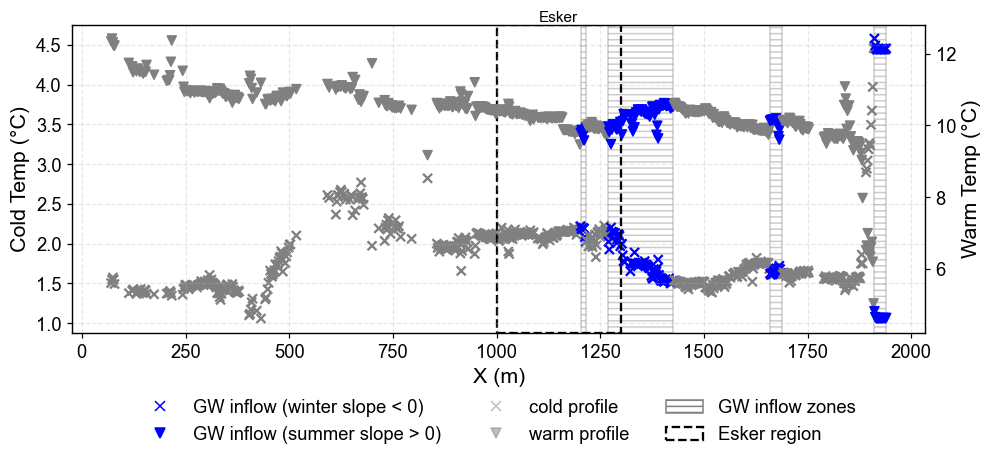

C:\Users\pparvizi24\AppData\Local\Temp\ipykernel_44048\1038650112.py:326: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


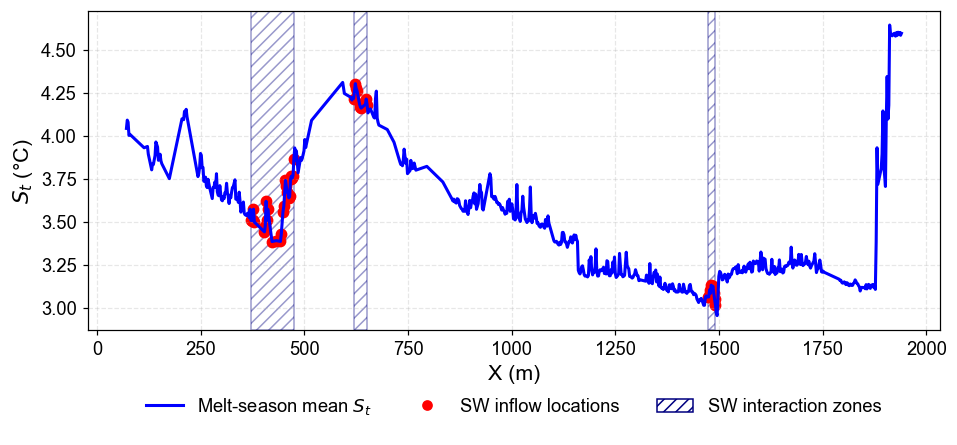

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


# Reset matplotlib to a clean and predictable state
mpl.rcParams.update(mpl.rcParamsDefault)


# Define a consistent and readable plotting style
# Font sizes are intentionally set larger for publication-quality figures
mpl.rcParams.update({
    "font.family": "Arial",
    "font.style": "normal",

    "font.size": 13,          # Base font size for all text
    "axes.labelsize": 14,     # Axis labels
    "axes.titlesize": 15,     # Axis titles
    "xtick.labelsize": 12,    # Tick labels
    "ytick.labelsize": 12,
    "legend.fontsize": 12,    # Legend text

    "figure.dpi": 110,        # On-screen resolution
    "savefig.dpi": 300,       # Export resolution
})


# ============================================================
# DATA PATHS - Update these paths for your local system
# ============================================================
DATA_BASE_DIR = "./data"  # Relative path from repository root

# Load DTS dataset
# This NetCDF file contains distributed temperature measurements along the stream
file = f"{DATA_BASE_DIR}/DTS/pallas_dts_data_f_6.nc"
data = xr.open_dataset(file)


# Define paths to external forcing data
# Discharge represents catchment-scale hydrological connectivity
# Snow depth is used to identify melt-season conditions
runoff_file = f"{DATA_BASE_DIR}/forcing/30_min_interval_discharge.csv"
snow_file   = f"{DATA_BASE_DIR}/forcing/snow_depth_kittila.csv"


# Read discharge time series
# Convert to a clean time-indexed structure compatible with xarray
runoff_df = pd.read_csv(runoff_file)
runoff_df["time"] = pd.to_datetime(runoff_df["datetime"])
runoff_df = runoff_df.set_index("time").sort_index()

Q = pd.to_numeric(runoff_df["Discharge"], errors="coerce").dropna()
Q_xr = xr.DataArray(Q.values, coords={"time": Q.index}, dims="time")


# Read snow depth observations
# Snow depth is reconstructed from separate date and time columns
snow_df = pd.read_csv(snow_file, low_memory=False)
snow_df["time"] = pd.to_datetime(
    snow_df["Year"].astype(str) + "-" +
    snow_df["Month"].astype(str).str.zfill(2) + "-" +
    snow_df["Day"].astype(str).str.zfill(2) + " " +
    snow_df["Time [Local time]"].astype(str),
    errors="coerce"
)

snow_df = snow_df.dropna(subset=["time"]).set_index("time").sort_index()
snow_col = "Snow depth [cm]"
snow_df[snow_col] = pd.to_numeric(snow_df[snow_col], errors="coerce")

# Negative values are non-physical and removed
snow_df.loc[snow_df[snow_col] < 0, snow_col] = 0.0

# Aggregate duplicate timestamps if present
snow_df = snow_df.groupby(snow_df.index).mean(numeric_only=True)

# Convert snow depth to meters and xarray format
snow_xr = xr.DataArray(
    (snow_df[snow_col] / 100.0).values,
    coords={"time": snow_df.index},
    dims="time"
)


# Define hydrological thresholds
# These values define when snowmelt-driven surface connectivity is active
snow_thresh = 0.0      # Snow must be present
Q_thresh = 0.2         # Discharge threshold for melt activation


# Align discharge and snow data to the DTS time axis
# This ensures all datasets are evaluated at the same timestamps
dts_time = data["time"]
Q_xr = Q_xr.interp(time=dts_time)
snow_xr = snow_xr.interp(time=dts_time)


# Identify nocturnal conditions
# Nighttime data minimize direct atmospheric heat exchange
night_mask = ((dts_time.dt.hour >= 22) | (dts_time.dt.hour < 6))

# Identify melt-season nights
# These conditions isolate periods of active snowmelt-driven inflow
melt_mask = night_mask & (snow_xr > snow_thresh) & (Q_xr > Q_thresh)
data_melt_night = data.sel(time=melt_mask)


# Build seasonal reference temperature envelopes
# Winter and summer reference states are derived from nocturnal distributions
data_night = data.sel(time=night_mask)
min_data = data_night["T"].quantile(0.25, dim="time").dropna(dim="x")
max_data = data_night["T"].quantile(0.75, dim="time").dropna(dim="x")


# Compute melt-season mean temperature profile
# This represents typical snowmelt thermal behavior along the stream
melt_mean = data_melt_night["T"].mean(dim="time").dropna(dim="x")
x = melt_mean["x"]


# Define rolling slope function
# A centered linear regression is applied along the stream coordinate
# This avoids noise amplification common in simple differencing
def rolling_slope(T, window):
    T_roll = T.rolling(x=window, center=True).construct("window")
    x_win = T["x"].rolling(x=window, center=True).construct("window")
    x_cent = x_win - T["x"].values[:, None]
    return (
        (x_cent * T_roll).mean("window")
        - x_cent.mean("window") * T_roll.mean("window")
    ) / (
        (x_cent**2).mean("window")
        - (x_cent.mean("window"))**2
    )


# Compute longitudinal temperature gradients
# Slopes are calculated for winter, summer, and melt-season profiles
window = 40
min_deriv  = rolling_slope(min_data, window)
max_deriv  = rolling_slope(max_data, window)
melt_deriv = rolling_slope(melt_mean, window)

# Additional melt-season metrics
# Variability highlights unstable inflow conditions
# Anomalies highlight localized cooling signatures
melt_var  = melt_deriv.rolling(x=10, center=True).std()
melt_anom = melt_mean - melt_mean.rolling(x=80, center=True).mean()


# Groundwater inflow classification
# GW zones are defined by seasonal slope reversal
gw_thresh = 0.0015
gw_class = xr.where((min_deriv < -gw_thresh) & (max_deriv > gw_thresh), 1, np.nan)

# Enforce spatial continuity to avoid isolated pixels
gw_class = xr.where(
    gw_class.rolling(x=10, center=True, min_periods=1).sum() > 5,
    1,
    np.nan
)

# Explicit spring identification
# Stable ~4–5 °C temperatures year-round indicate groundwater sources
spring_mask = (
    (min_data > 4) & (min_data < 5) &
    (max_data > 4) & (max_data < 5)
)
gw_class = xr.where(spring_mask, 1, gw_class)


# Surface-water inflow classification
# SW inflows are characterized by high variability and cold melt signatures
var_thresh = np.nanpercentile(melt_var, 80)
cold_anom = melt_anom < -0.15
strong_slope = melt_deriv > np.nanpercentile(melt_deriv, 80)

sw_class = xr.where(
    (melt_var > var_thresh) & (cold_anom | strong_slope),
    1,
    np.nan
)

# Prevent overlap between GW and SW zones
sw_class = xr.where(np.isfinite(gw_class), np.nan, sw_class)

# Enforce spatial coherence
sw_class = xr.where(
    sw_class.rolling(x=5, center=True, min_periods=1).sum() > 2,
    1,
    np.nan
)

# Remove unreliable upstream boundary effects
sw_class = xr.where(x > 1800, np.nan, sw_class)

# Expand SW zones to include adjacent supporting segments
sw_core = sw_class.fillna(0).astype(int)
sw_class_ext = xr.where(
    sw_core.rolling(x=8, center=False, min_periods=1).max() == 1,
    1,
    np.nan
)

gw_mask = gw_class.fillna(0).values
sw_mask = sw_class_ext.fillna(0).values


# Helper function to extract continuous spatial segments
# This is used for drawing shaded inflow zones
def extract_segments(x, mask):
    segments = []
    in_segment = False
    for i in range(len(x)):
        if mask[i] == 1 and not in_segment:
            start = x[i]
            in_segment = True
        if in_segment and (mask[i] == 0 or i == len(x) - 1):
            end = x[i - 1] if mask[i] == 0 else x[i]
            segments.append((start, end))
            in_segment = False
    return segments

gw_segments = extract_segments(x.values, gw_mask)
sw_segments = extract_segments(x.values, sw_mask)


# Esker reference region
# This geomorphological unit is highlighted for interpretation
esker_start = 1000
esker_end   = 1300


# FIGURE 1 – Groundwater inflows
fig1 = plt.figure(figsize=(10, 5))
gs1 = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.2)

ax_w = fig1.add_subplot(gs1[0])
ax_s = ax_w.twinx()
ax_leg1 = fig1.add_subplot(gs1[1])
ax_leg1.axis("off")

for xs, xe in gw_segments:
    ax_w.axvspan(xs, xe, facecolor="none", edgecolor="grey", hatch="---", alpha=0.4)

ax_w.scatter(x, min_data, c=np.where(gw_mask == 1, "blue", "grey"), marker="x", s=35)
ax_s.scatter(x, max_data, c=np.where(gw_mask == 1, "blue", "grey"), marker="v", s=35)

ax_w.set_ylabel("Cold Temp (°C)")
ax_s.set_ylabel("Warm Temp (°C)")
ax_w.set_xlabel("X (m)")
ax_w.grid(True, linestyle="--", alpha=0.3)

ax_w.axvspan(esker_start, esker_end, facecolor="none", edgecolor="black", linestyle="--", linewidth=1.5)

# Optional: label the esker
ax_w.text(
    0.5 * (esker_start + esker_end),
    ax_w.get_ylim()[1],
    "Esker",
    ha="center",
    va="bottom",
    fontsize=10,
    rotation=0
)

ax_leg1.legend(
    [
        plt.Line2D([], [], color="blue", marker="x", linestyle=""),
        plt.Line2D([], [], color="blue", marker="v", linestyle=""),
        plt.Line2D([], [], color="grey", marker="x", linestyle="", alpha=0.5),
        plt.Line2D([], [], color="grey", marker="v", linestyle="", alpha=0.5),
        mpl.patches.Patch(facecolor="none", edgecolor="grey", hatch="---"),
        mpl.patches.Patch(facecolor="none", edgecolor="black", linestyle="--", linewidth=1.5),
    ],
    [
        r"GW inflow (winter slope < 0)",
        r"GW inflow (summer slope > 0)",
        "cold profile",
        "warm profile",
        "GW inflow zones",
        "Esker region",
    ],
    loc="center",
    bbox_to_anchor=(0.5, 0.35),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()


# FIGURE 2 – Surface-water inflows
fig2 = plt.figure(figsize=(10, 5))
gs2 = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.12)

axm = fig2.add_subplot(gs2[0])
ax_leg2 = fig2.add_subplot(gs2[1])
ax_leg2.axis("off")

for xs, xe in sw_segments:
    axm.axvspan(xs, xe, facecolor="none", edgecolor="navy", hatch="///", alpha=0.4)

axm.plot(x, melt_mean, color="blue", lw=2.0)
axm.scatter(x[sw_mask == 1], melt_mean.values[sw_mask == 1], color="red", s=45)

axm.set_ylabel(r"$S_{\mathrm{t}}$ (°C)")
axm.set_xlabel("X (m)")
axm.grid(True, linestyle="--", alpha=0.3)

ax_leg2.legend(
    [
        plt.Line2D([], [], color="blue", linewidth=2.0),
        plt.Line2D([], [], color="red", marker="o", linestyle=""),
        mpl.patches.Patch(facecolor="none", hatch="///", edgecolor="navy"),
    ],
    [
        r"Melt-season mean $S_{\mathrm{t}}$",
        "SW inflow locations",
        "SW interaction zones",
    ],
    loc="center",
    bbox_to_anchor=(0.5, 0.35),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()


In [ ]:
import xarray as xr
from pathlib import Path
import pandas as pd

# ------------------------------------------------------------
# Single DTS NetCDF file
# ------------------------------------------------------------
nc_file = Path(f"{DATA_BASE_DIR}/DTS/pallas_dts_data_f_6.nc")

# ------------------------------------------------------------
# Print time coverage
# ------------------------------------------------------------
try:
    ds = xr.open_dataset(nc_file)

    if "time" not in ds:
        print(f"{nc_file.name}: NO time coordinate")
    else:
        t_start = pd.to_datetime(ds.time.values[0])
        t_end   = pd.to_datetime(ds.time.values[-1])
        duration = t_end - t_start

        print(
            f"{nc_file.name}\n"
            f"  Start    : {t_start}\n"
            f"  End      : {t_end}\n"
            f"  Duration : {duration}\n"
        )

    ds.close()

except Exception as e:
    print(f"{nc_file.name}: ERROR -> {e}\n")


pallas_dts_data_f_6.nc
  Start    : 2021-06-15 00:30:00
  End      : 2024-09-25 11:30:00
  Duration : 1198 days 11:00:00



In [ ]:
# ============================================================
# EXPORT GW AND SW LOCATIONS (SLOPE-BASED) TO CSV
# ============================================================

# Convert segments to DataFrames
gw_df = pd.DataFrame(gw_segments, columns=["x_start_m", "x_end_m"])
sw_df = pd.DataFrame(sw_segments, columns=["x_start_m", "x_end_m"])

# Add mid-point location (useful as representative inflow point)
gw_df["x_mid_m"] = 0.5 * (gw_df["x_start_m"] + gw_df["x_end_m"])
sw_df["x_mid_m"] = 0.5 * (sw_df["x_start_m"] + sw_df["x_end_m"])

# Add segment length
gw_df["length_m"] = gw_df["x_end_m"] - gw_df["x_start_m"]
sw_df["length_m"] = sw_df["x_end_m"] - sw_df["x_start_m"]

# Add classification metadata
gw_df["method"] = "Seasonal slope contrast (winter dT/dx < 0, summer dT/dx > 0)"
sw_df["method"] = "Melt-season slope variability and cold anomaly"

# Optional: flag whether GW segment intersects esker
gw_df["intersects_esker"] = (
    (gw_df["x_end_m"] >= esker_start) &
    (gw_df["x_start_m"] <= esker_end)
)

# File paths for output (will be saved in repository root)
gw_out = "GW_inflow_locations_slope.csv"
sw_out = "SW_inflow_locations_slope.csv"

# Save CSV files
gw_df.to_csv(gw_out, index=False)
sw_df.to_csv(sw_out, index=False)

print("CSV export completed:")
print(gw_out)
print(sw_out)

gw_df, sw_df


CSV export completed:
C:\Users\pparvizi24\OneDrive - University of Oulu and Oamk\Parsa-PHD-OneDrive\DTS\Clone_DTS\Final-Final-Clone DTS Article\GW_inflow_locations_slope.csv
C:\Users\pparvizi24\OneDrive - University of Oulu and Oamk\Parsa-PHD-OneDrive\DTS\Clone_DTS\Final-Final-Clone DTS Article\SW_inflow_locations_slope.csv


(   x_start_m   x_end_m    x_mid_m  length_m  \
 0   1203.037  1215.212  1209.1245    12.175   
 1   1270.000  1426.248  1348.1240   156.248   
 2   1659.605  1688.013  1673.8090    28.408   
 3   1911.224  1939.633  1925.4285    28.409   
 
                                               method  intersects_esker  
 0  Seasonal slope contrast (winter dT/dx < 0, sum...              True  
 1  Seasonal slope contrast (winter dT/dx < 0, sum...              True  
 2  Seasonal slope contrast (winter dT/dx < 0, sum...             False  
 3  Seasonal slope contrast (winter dT/dx < 0, sum...             False  ,
    x_start_m   x_end_m    x_mid_m  length_m  \
 0    371.069   474.558   422.8135   103.489   
 1    618.630   651.097   634.8635    32.467   
 2   1472.919  1491.182  1482.0505    18.263   
 
                                            method  
 0  Melt-season slope variability and cold anomaly  
 1  Melt-season slope variability and cold anomaly  
 2  Melt-season slope variability 